In [1]:
#Necessary imports
!pip install bitsandbytes datasets -U
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
import torch
from datasets import load_dataset, Dataset
from google.colab import drive
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import bitsandbytes
import os
from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

torch.cuda.empty_cache()
import gc
gc.collect()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

98

In [2]:
#environment preparation
drive.mount('/content/drive/')
path = '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi'

#!pip install -q transformers datasets accelerate peft bitsandbytes

#!pip install -U bitsandbytes

model_name = "openai-community/gpt2"

# Define the BitsAndBytesConfig for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, # Use bfloat16 for computation
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Set the padding token to be the EOS token
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True
)


Mounted at /content/drive/


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
# data preparation

dataset = load_dataset("suayptalha/Poetry-Foundation-Poems")

# Assuming dataset initially only has a 'train' split,
# split the 'train' split into training and testing sets
train_test_split_dataset = dataset['train'].train_test_split(test_size=0.2) # Allocate 20% for testing

def tokenize(example):
    tokenized_output = tokenizer(example["Poem"], padding="max_length", truncation=True, max_length=512)
    # Add labels for causal language modeling training
    tokenized_output["labels"] = tokenized_output["input_ids"]
    return tokenized_output

# Apply tokenization to the new splits
tokenized_dataset = train_test_split_dataset.map(tokenize, batched=True, remove_columns=[ "Title", "Poet", "Tags"])

os.environ["WANDB_DISABLED"] = "true"

# Prepare model for LoRA training
model = prepare_model_for_kbit_training(model)
config = LoraConfig(r=8, lora_alpha=32, target_modules=["c_attn"], lora_dropout=0.05, bias="none", task_type="CAUSAL_LM")
model = get_peft_model(model, config)
model.print_trainable_parameters()

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

PoetryFoundationData.csv:   0%|          | 0.00/23.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13854 [00:00<?, ? examples/s]

Map:   0%|          | 0/11083 [00:00<?, ? examples/s]

Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [4]:
#Testing the model before training - seguir una frase
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sea is blue, the sky is red. The sun shines in a bright golden light and all things are green for days to come when we will be able to live our lives with dignity as human beings without fear of death or suffering."



In [5]:
#Testing the model before training - seguir una instrucció
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write a poem about the sea and the sky, or whatever it is you like to call them.
To quote one of my friends on Facebook: "If I'm going in with an ego that's not looking out for me (myself), then maybe we should just let go." It was only when people started making up stories they knew who those other self-absorbed ones were—or weren't really at all! When your first book comes along as well...it doesn´t matter what kind [the author] thinks she knows yet; there are no books written by her anymore!"




In [6]:

training_args = TrainingArguments(
    output_dir=os.path.join(path, "deep_optimized"),
    per_device_train_batch_size=2,  # Small due to Colab memory limits
    gradient_accumulation_steps=16,  # Simulates effective batch size = 16
    num_train_epochs=5,  # Higher for better generalization
    learning_rate=3e-5,  # Safer than 1e-4; avoids divergence
    weight_decay=0.01,  # Encourages sparsity, reduces overfitting
    lr_scheduler_type="cosine",  # Cosine decay works great for transformers
    warmup_steps=250,  # Gradual ramp-up prevents loss spikes
    fp16=True,  # Great for Colab GPUs
    logging_steps=25,
    save_strategy="epoch",
    save_total_limit=2,
    greater_is_better=False,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test']
)


trainer.train()


<ipython-input-6-08cb5e971944>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
25,7.262200
50,7.179300
75,7.237000
100,6.969200
125,6.871400
150,6.488900
175,6.030900
200,5.230900
225,4.555300
250,3.995200


Step,Training Loss
25,7.262200
50,7.179300
75,7.237000
100,6.969200
125,6.871400
150,6.488900
175,6.030900
200,5.230900
225,4.555300
250,3.995200


TrainOutput(global_step=1735, training_loss=3.090644192214658, metrics={'train_runtime': 2830.6818, 'train_samples_per_second': 19.577, 'train_steps_per_second': 0.613, 'total_flos': 1.452970226221056e+16, 'train_loss': 3.090644192214658, 'epoch': 5.0})

In [7]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 2.312107563018799, 'eval_runtime': 59.035, 'eval_samples_per_second': 46.938, 'eval_steps_per_second': 5.878, 'epoch': 5.0}


In [11]:
#Testing the model before training - seguir una frase
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sea is blue, the sky is red, and everything that has been there for so long feels like it's going to be over. I've always felt as though my life was changed by these things; they're now here in our heads, but not really at all what we think about them."

A few days later on August 28th, when she finally heard from her husband, he answered his phone: "I have a new boyfriend!" She had never known him before. He'd already married another woman – just six years earlier – because of an affair with then-boyfriend. And suddenly this young man couldn't make out anything else than how different their lives were! What must have happened? Wasn'he jealous or something… But why would someone ask such questions?? It seemed odd that some people who love women even find themselves attracted only to men whose sexual preferences are much more flexible than mine. A week after getting off work (and having sex) again, Mr Thomas told me - very politely - that if Mrs Thomas wanted to get engaged someday,

In [9]:
#Testing the model before training - seguir una instrucció
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write a poem about the sea and the sky, "and of your life I am satisfied," said Jesus. Then he looked at him with joy: "I know not what thou hast done to me; but God will tell thee this." And when He had finished speaking Him knew that his name was called John in all things—a man who has always been one day dreaming of himself as Lord or Savior.


In [12]:

# Merge LoRA into base model
merged_model = model.merge_and_unload()

# Now merged_model is a standard AutoModelForCausalLM
# You can save it as a normal model
merged_model.save_pretrained(os.path.join(path, "funciona_gpt2"))
tokenizer.save_pretrained(os.path.join(path, "funciona_gpt2"))



('/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/funciona_gpt2/tokenizer_config.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/funciona_gpt2/special_tokens_map.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/funciona_gpt2/vocab.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/funciona_gpt2/merges.txt',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/funciona_gpt2/added_tokens.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/funciona_gpt2/tokenizer.json')

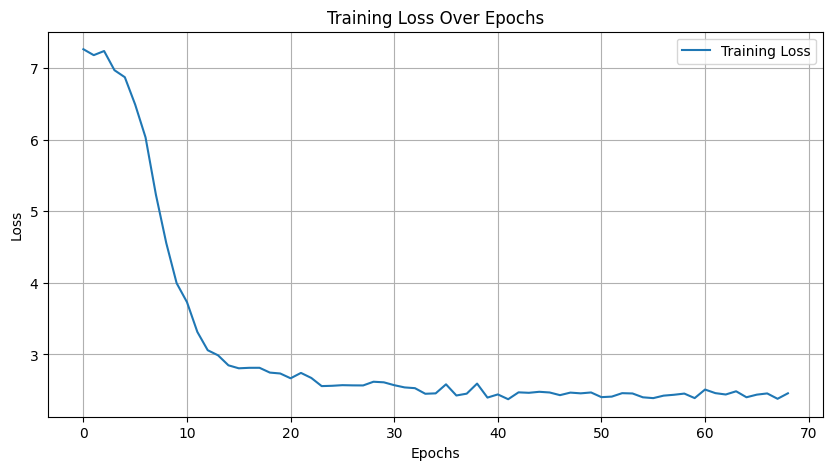

In [14]:
import matplotlib.pyplot as plt

# Assuming you have a `trainer` object after training
history = trainer.state.log_history

# Extract training and validation losses
train_loss = [log['loss'] for log in history if 'loss' in log]

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()